# Classification using Bayesian Gaussian Mixture
Even though the results of the previus classifier are not too sensible to different choices for the number of mixtures  a little drowback of the that classifier is that we need to specify the number of components in the mixture models. Here we present a similar approch that instead of fixing the number of components and brutally applyaing expectation-maximization, only fixes tha maximum number of componentsa and then adds a regularization by integrating information from prior distributions.

In [19]:
#load libraries
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.discriminant_analysis
import sklearn.mixture
import librosa.display
import numpy
import random
import pandas
import seaborn
import json
import operator

### Load Features
After the extraction of the features using the code provided in **Feature_Extraction.ipynb** we can simply load them from the .txt files (this will save time since feature extration can take a while).

In [20]:
with open('x.txt', 'r') as filehandle:
    y = json.load(filehandle)

In [ ]:
with open('SR.txt', 'r') as filehandle:
    SR = json.load(filehandle)
with open('MFCC.txt', 'r') as filehandle:
    MFCC = json.load(filehandle)

In [21]:
##convert mfccs from list to numpy array that are faster to work with
x={}
for sr in SR:
    x[sr]={}
    for n_mfcc in MFCC:
        x[sr][n_mfcc]=[]
            
for sr in y:
    for n_mfcc in y[sr]:
        for t in y[sr][n_mfcc]:
            x[int(sr)][int(n_mfcc)].append({"artist": t["artist"],
                                            "song": t["song"],
                                            "mfcc":numpy.asarray(t["mfcc"])})

### Create a Balanced Train-Test split
Now we create a random, but balanced, train-test split, meaning that we control randomness in a way to use for training the model the same number of songs per artist (around 3/4 for train and 1/4 for test)

In [22]:
#create list of artists
artistlist=[]
for t in x[SR[0]][MFCC[0]]:
    if t["artist"] not in artistlist:
        artistlist.append(t["artist"])
artistlist.sort()
#print(artistlist)


#count number of songs for each artist
songcount={}
for t in x[SR[0]][MFCC[0]]:
    if t["artist"] not in songcount:
        songcount[t["artist"]] = 1
    else:
        songcount[t["artist"]]+=1
#print(songcount)


#find number of songs for the artist having the smallest number of songs
artist_with_min = min(songcount.keys(), key=(lambda k: songcount[k]))
min_song=songcount[artist_with_min]


#number of song per artist to use as train
N=int(min_song*3/4)
#print(N)


#Create a list of songs per each artist
songs={}
for t in x[SR[0]][MFCC[0]]:
    if t["artist"] not in songs:
        songs[t["artist"]]=[]
    songs[t["artist"]].append(t["song"])
#print(songs)

###create split
split={}
for artist in artistlist:
    split[artist]={}
    split[artist]["train"],split[artist]["test"]=sklearn.model_selection.train_test_split(songs[artist]
                                                                                          ,train_size=N
                                                                                          ,random_state=1)
songtrain=[]
songtest=[]
for artist in artistlist:
    songtrain = songtrain + split[artist]["train"]
    songtest = songtest + split[artist]["test"]
                     

#print(songtrain)
#print(songtest)

In [23]:
##create dictionary such that to each artist correspond the list of its real songs
##this will be usefull to compare predictions with real values
song_and_artist_test={}
for t in x[2500][4]:
    if t["artist"] not in song_and_artist_test:
        song_and_artist_test[t["artist"]] = []
    if t["song"] in songtest:
        song_and_artist_test[t["artist"]].append(t["song"])

# Classification using a BGM to model each artist:
Here we run the model letting vary the "quality" of features extracted.

In [25]:
#SR=[2500]    #to test
#MFCC=[4]     #to test


#initialize CM, this will store the confusion matrices of all models
CM={}
for sr in SR:
    CM[sr]={}
    for n_mfcc in MFCC:
        CM[sr][n_mfcc]=0

#loop over samplig rates and number of mfcc
for sr in SR:
    for n_mfcc in MFCC:
        print((sr,n_mfcc))

        
        #train a BGM for each artist
        bgmdict={}
        for artist in artistlist:
            features_train=numpy.empty((1,n_mfcc))
            for t in x[sr][n_mfcc]:
                if t["artist"]==artist:
                    if t["song"] in songtrain:
                        features_train=numpy.vstack((features_train, t["mfcc"]))
            features_train=numpy.delete(features_train,0,0)
            bgm = sklearn.mixture.BayesianGaussianMixture(n_components=64, covariance_type='diag'
                                                          ,weight_concentration_prior_type='dirichlet_distribution'
                                                          ,max_iter=30,tol=0.01)
            bgm.fit(features_train)
            bgmdict[artist]=bgm    

            
        #create a matrix with test features and also ordered labels for song adn arstist
        features_test=numpy.empty((1,n_mfcc))
        artist_labels_test=[]
        song_labels_test=[]
        for t in x[sr][n_mfcc]:
            if t["song"] in songtest:
                features_test=numpy.vstack((features_test, t["mfcc"]))
                for _ in range(t["mfcc"].shape[0]):
                    artist_labels_test.append(t["artist"])
                    song_labels_test.append(t["song"])
        features_test=numpy.delete(features_test,0,0)
        
        #frame predictions
        artist_pred_bgm=[]
        for t in features_test:
            score={}
            for artist in artistlist:
                model = bgmdict[artist]
                score[artist]= model.score(numpy.reshape(t,(1,-1)))
            pred = max(score, key=lambda key: score[key])
            artist_pred_bgm.append(pred)
        
   
        #songs predictions
        out_bgm={}
        for song in songtest:
            v=[artist_pred_bgm[u] for u in range(len(artist_pred_bgm)) if song_labels_test[u] == song]
            out_bgm[song]=max(set(v), key=v.count)
        out_bgm
            
            
        ##create dictioary such that to each artist correspond the list of its predicted songs
        song_and_artist_pred_bgm={}
        for key,value in out_bgm.items():
            if value not in song_and_artist_pred_bgm:
                song_and_artist_pred_bgm[value] = []
            song_and_artist_pred_bgm[value].append(key)
            
        ##initialize confusion matrix   
        N_art=len(artistlist)
        conf_matrix_bgm = pandas.DataFrame(numpy.zeros(shape=(N_art,N_art)), columns = artistlist, index=artistlist)

        ##place in position (i,j) the number of songs from artist i predicted as of artist j
        for artist_t, listsong_t in song_and_artist_test.items():
            for artist_p, listsong_p in song_and_artist_pred_bgm.items():
                tot=len(set(listsong_t).intersection(listsong_p))
                conf_matrix_bgm[artist_p][artist_t]=tot
        #print(conf_matrix_gmm)

        #store confusion matrix
        CM[sr][n_mfcc]=conf_matrix_bgm

(2500, 4)


c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try dif

(2500, 8)


c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try dif

(2500, 12)


c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try dif

(2500, 16)


c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try dif

(2500, 20)


c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try dif

(5000, 4)


c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try dif

(5000, 8)


c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try dif

(5000, 12)


c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try dif

(5000, 16)


c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try dif

(5000, 20)


c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try dif

(7500, 4)


c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try dif

(7500, 8)


c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try dif

(7500, 12)


c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try dif

(7500, 16)


c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try dif

(7500, 20)


c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try dif

(10000, 4)


c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try dif

(10000, 8)


c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try dif

(10000, 12)


c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try dif

(10000, 16)


c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try dif

(10000, 20)


c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
c:\users\aless\appdata\local\programs\python\python37\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try dif

# Performances Evaluation
Now we use all the confusion matrices stored in **CM** to evaluate performances. To this end we calculate class specific *precison* and *recall* and then we will average the values. This *macro*-averaged measures are suitable for assessing performaces of our models because every class has almost the same number of observations. However we will also use *micro*-averaged measures that are more conservative and tend to penalize models that make imbalanced predictions. Moreover we will also evaluate F1 score (both micro and Macro averaged).

In [26]:
#inizialize dictionaries for macro and micro measures of performance
MACRO={}
micro={}
for sr in SR:
    MACRO[sr]={}
    micro[sr]={}
    for n_mfcc in MFCC:
        MACRO[sr][n_mfcc]=0
        micro[sr][n_mfcc]=0

#calculate precison and recall (Macro-averaged)
for sr in SR:
    for n_mfcc in MFCC:
        cm=numpy.asarray(CM[sr][n_mfcc])
        recall = numpy.mean(numpy.diag(cm) / numpy.sum(cm, axis = 1))
        precision = numpy.mean(numpy.diag(cm) / numpy.sum(cm, axis = 0))
        F1 = (2*precision*recall)/(precision+recall)
        MACRO[sr][n_mfcc]={"recall":round(recall,3),"precision":round(precision,3),"F1":round(F1,3)}
        
#calculate precison and recall (Micro-averaged)
for sr in SR:
    for n_mfcc in MFCC:
        cm=numpy.asarray(CM[sr][n_mfcc])
        recall = (numpy.trace(cm) / numpy.sum(numpy.sum(cm, axis = 1)))
        precision = (numpy.trace(cm) / numpy.sum(numpy.sum(cm, axis = 0)))
        F1 = (2*precision*recall)/(precision+recall)
        micro[sr][n_mfcc]={"recall":round(recall,3),"precision":round(precision,3),"F1":round(F1,3)}

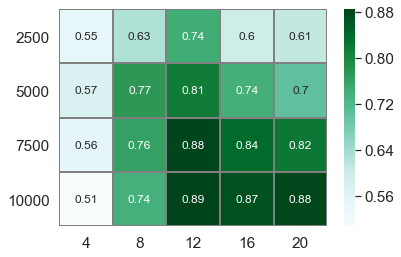

In [27]:
#visualization of MACRO-F1 index
MF1 = pandas.DataFrame(numpy.zeros(shape=(len(SR),len(MFCC))), columns = MFCC, index=SR)
for sr in SR:
    for n_mfcc in MFCC:
        MF1[n_mfcc][sr]=MACRO[sr][n_mfcc]["F1"]

#nice heatmap
seaborn.set(font_scale=1.4)
seaborn.heatmap(MF1, annot=True,annot_kws={"size": 12}
                  ,linewidths = 1,linecolor="gray",cmap="BuGn")
plt.yticks(rotation=0, horizontalalignment='right')
plt.show()

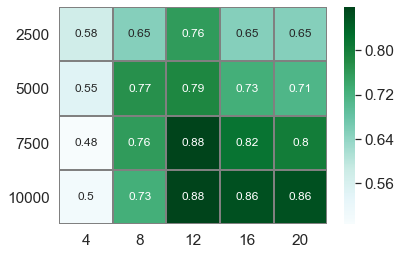

In [28]:
#visualization of micro-F1 index
mF1 = pandas.DataFrame(numpy.zeros(shape=(len(SR),len(MFCC))), columns = MFCC, index=SR)
for sr in SR:
    for n_mfcc in MFCC:
        mF1[n_mfcc][sr]=micro[sr][n_mfcc]["F1"]

#nice heatmap
seaborn.set(font_scale=1.4)
seaborn.heatmap(mF1, annot=True,annot_kws={"size": 12}
                  ,linewidths = 1,linecolor="gray",cmap="BuGn")
plt.yticks(rotation=0, horizontalalignment='right')
plt.show()